# Computational Demo

We are interested in an upper bound on the gradient of a regression mean.

We consider a box and find the greatest gradient associated with each training point, seperately, within that box. We assume an RBF covariance. We then add up these gradients and this provides an upper bound for that box (as these training points, at worst, will lie on-top of each other). We can then split the box and repeat with the smaller boxes.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def k(X,Xprime,l=1):
    """Full kernel. Get covariance (using RBF with lengthscale l) between x and xprime"""
    res = np.zeros([X.shape[0],Xprime.shape[0]])
    for i,x in enumerate(X):
        for j,xprime in enumerate(Xprime):
            res[i,j] = np.exp(-.5*np.dot((x-xprime),(x-xprime).T)/(l**2))
    return res

In [34]:
def getpred2grad(Xtest,X,Y,dim,l):
    """Get the gradient at Xtest, wrt Xtest_dim"""
    """dim is the dimension that's being differentiated."""
    assert len(Xtest.shape)==2
    assert Xtest.shape[1]==X.shape[1]
    assert X.shape[0]==Y.shape[0]
    assert dim<Xtest.shape[1]
    assert dim>=0
    assert l>=0

    rets = []
    for xtest in Xtest:
        alpha = np.dot(np.linalg.inv(k(X,X,l)+np.eye(len(X))),Y)
        pred = 0
        K = k(xtest[None,:],X,l)  
        for i,(a,kval) in enumerate(zip(alpha,K.T)):
            pred+=a*kval*((X[i,dim]-xtest[dim])/(l**2))
        rets.append(pred)
    return np.array(rets)

def compute_box_bound(b,X,Y,l,dim):
    """Computes an upper bound for the value of the gradient inside /one/ box, b"""
    
    peakgrad = 0  #total over all training points
    peaklocs = [] #vector of gradient peaks
    peakvals = [] #values of the gradients at these peaks
    
    #loop over all training points.
    for i in range(X.shape[0]):
        x = X[i:(i+1),:]
        y = Y[i:(i+1),:]
        testx = x.copy()
        
        #testx contains the location at which the gradient is maximum
        #we know from simple calculus for the RBF with lengthscale 'l' that the maximum
        #gradient is at:
        testx[0,dim] = x[0,dim]-(l)*np.sign(y[0,0])
        
        ####Test code to confirm this is a gradient peak####
        testxdelta = testx.copy()
        delta = 0.0000001
        testxdelta[0,dim]+=delta
        assert np.abs((getpred2grad(testx,x,y,0,l)-getpred2grad(testxdelta,x,y,0,l))/delta)<0.001, print("Error %0.6f should be zero" % ((getpred2grad(testx,x,y,0,l)-getpred2grad(testxdelta,x,y,0,l))/delta))
        ####################################################
        
        #this is to store the location of the peak inside the boundary
        boundarymaxpeak = np.ones_like(testx)*np.NaN 

        #first we need to look at the derivative dimension, is the actual peak inside the boundary
        #(in this dimension)
        if (testx[0,dim]>b[dim][0]) & (testx[0,dim]<b[dim][1]):
            #the peak of the derivative-rbf in the differentiated axis is inside the boundary.
            boundarymaxpeak[dim] = testx[0,dim] #we can set this as the location of the maximum
            maxgrad = getpred2grad(testx,x,y,dim,l) #get the value of the actual peak
        else:            
            #the peak is outside the boundary, check at which boundary is most positive.
            #todo this could be done without actually computing the values (just look which is closer!!)
            testpoints = np.r_[testx.copy(),testx.copy()]
            testpoints[0,dim]=b[dim][0]
            testpoints[1,dim]=b[dim][1]
            boundaryedges = getpred2grad(testpoints,x,y,dim,l)
            maxgrad = np.max(boundaryedges) #saves the value of the peak, it might be negative!
            boundarymaxpeak[0,dim] = testpoints[np.argmax(boundaryedges),dim]
            
        #at this point 'boundarymaxpeak' contains NaNs except for the dimension we've differentiated
        
        #now we look at the other dimensions...
        #if maxgrad>0 then we're trying to get to the greatest point in each other dimension
        #as the slide taken at the maxgrad location is positive everywhere over the slide
        #if it's negative then we're trying to get the least negative point
        #(somewhere on the boundary)
        for d in range(x.shape[1]):
            if d==dim:
                continue #skip the differentiated dimension
            
            if (testx[0,d]>b[d][0]) & (testx[0,d]<b[d][1]): #if the peak is inside the boundary (in this dimension)
                if maxgrad>0: #if the peak is positive
                    boundarymaxpeak[0,d] = testx[0,d]
                    continue #we're done
                    #if it's not positive, then even though this dimension has the
                    #peak inside its boundaries, the peak is so far away that we actually
                    #have the negative peak inside/near the box. Hence we need to find
                    #the boundaries that are least negative.

            #if maxgrad is negative or we're outside the boundary, we need to check the
            #boundaries
            #todo: combine duplicate code...
            #this checks which boundary is most positive...
            testpoints = np.r_[testx.copy(),testx.copy()]
            testpoints[0,d]=b[d][0]
            testpoints[1,d]=b[d][1]
            testpoints[:,dim] = boundarymaxpeak[0,dim]
            boundaryedges = getpred2grad(testpoints,x,y,dim,l)
            #...and sets the appropriate coordinate of 'boundarymaxpeak' to the boundary with the
            #most positive value
            boundarymaxpeak[0,d] = testpoints[np.argmax(boundaryedges),d]
            
        peakval = getpred2grad(boundarymaxpeak,x,y,dim,l)
        peakgrad += peakval
        peaklocs.append(boundarymaxpeak)
        peakvals.append(peakval)
    return peakgrad, peaklocs, peakvals

### Demo

Here we consider a training set of 3 points (X), one is positive the other two, negative.

We search a bounding box B from -10 to +20.

We want to find an upper bound on the gradient.

In [125]:
B = []
#B.append(np.array([[100,110],[115,120],[130,140]])) #boundaries
#X = np.array([[1.1,2.2,3.3],[2,2.9,3.1],[4.1,5.3,3.0]])*1.0
B.append(np.array([[-10.0,20.0],[-10.0,20.0]])) #boundaries
#X = np.array([[1.1,2.2],[2,2.9],[4.1,5.3]])*1.0
#Y = np.array([[1],[-1],[-1]])*1.0

X = np.array([[1.1,2.2],[2,2.9],[4.1,5.3],[2.2,3.0],[4.1,2.3],[5.2,5.3]])*1.0
Y = np.array([[1],[-1],[-1],[1],[1],[1]])*1.0
peakgrads =[np.NaN]*len(B)


Here we iteratively compute the gradient, then split the box with the largest gradient in two (width-ways, keeping the boxes as square as possible - I don't know if that's the right thing to do!).

We could do far better and try to split the data up with the boxes as much as possible.

I print the upper bound each iteration - showing how each time we push the bound down a little more.

In [126]:
l = 2.0
totalits = 60
for it in range(totalits):
    
    #loop through all the boxes, and compute any that aren't yet computed (check if 'computed')
    for i in range(len(B)):
        if peakgrads[i] is np.NaN:
            peakgrad, peaklocs, peakvals = compute_box_bound(B[i],X,Y,l,0)            
            peakgrads[i] = peakgrad
    print(np.max(np.array([p[0,0] for p in peakgrads if p is not np.NaN])))
    
    #stop here if last iteration so we don't split the box again
    if it==totalits-1:
        break
        
    #pick box with max gradient bound
    maxbox = np.argmax(np.array(peakgrads))
    
    #pick box with max gradient*width bound
    #widths = np.array([np.diff(b[0]) for b in B])
    #maxbox = np.argmax(np.array(peakgrads)[:,:,0]*widths)

    b = B[maxbox].copy()
    newb = []
    B.pop(maxbox)
    peakgrads.pop(maxbox)
    
    #decide on which way we're going to halve the box (we want the longest dimension)
    dimtosplit = np.argmax(np.diff(b))
    mid = (b[dimtosplit][0]+b[dimtosplit][1])/2 #the midpoint of this dimension
    
    #find the start and end coordinates of the two new boxes
    #(they're the same as the old box, except for the dimtosplit which has
    #either the start or end coordinates at the mid point).
    
    newbstarts = b[:,0].copy()
    newbends = b[:,1].copy()
    newbends[dimtosplit] = mid
    newb = np.c_[newbstarts,newbends]
    B.append(newb) #add the 1st new box 
    newbstarts = b[:,0].copy()
    newbends = b[:,1].copy()
    newbstarts[dimtosplit] = mid
    newb = np.c_[newbstarts,newbends]
    B.append(newb) #add the 2nd new box
    #add the two entries to the peakgrads list with NaN to mark it for computation.
    peakgrads.extend([np.NaN,np.NaN])
#peakgrads will contain an upper bound on the gradient within each box

0.909795989569
0.859830370902
0.856996718332
0.856996718332
0.856996718332
0.658631008403
0.652795598674
0.550513717304
0.550513717304
0.550513717304
0.506545969995
0.500600351316
0.47552514543
0.465976102326
0.465888487289
0.447232205856
0.443768512458
0.430958434174
0.419970730978
0.410187829961
0.402465224676
0.401379917972
0.382174041654
0.363539431478
0.359177528764
0.355382249825
0.343763427157
0.338744666057
0.337862108743
0.32670869593
0.32136780224
0.314781025926
0.309614735356
0.308124607442
0.307729370364
0.305656447665
0.30469490289
0.302219931804
0.301120937359
0.298252652167
0.296278065304
0.296278065303
0.296269297776
0.293963720945
0.292842744868
0.292822578733
0.291810616642
0.291604468798
0.28799527427
0.287808507976
0.286950214689
0.286469012325
0.284768503438
0.282115182546
0.279030264749
0.278051267902
0.273739181196
0.272797883325
0.270986349497
0.269566826468


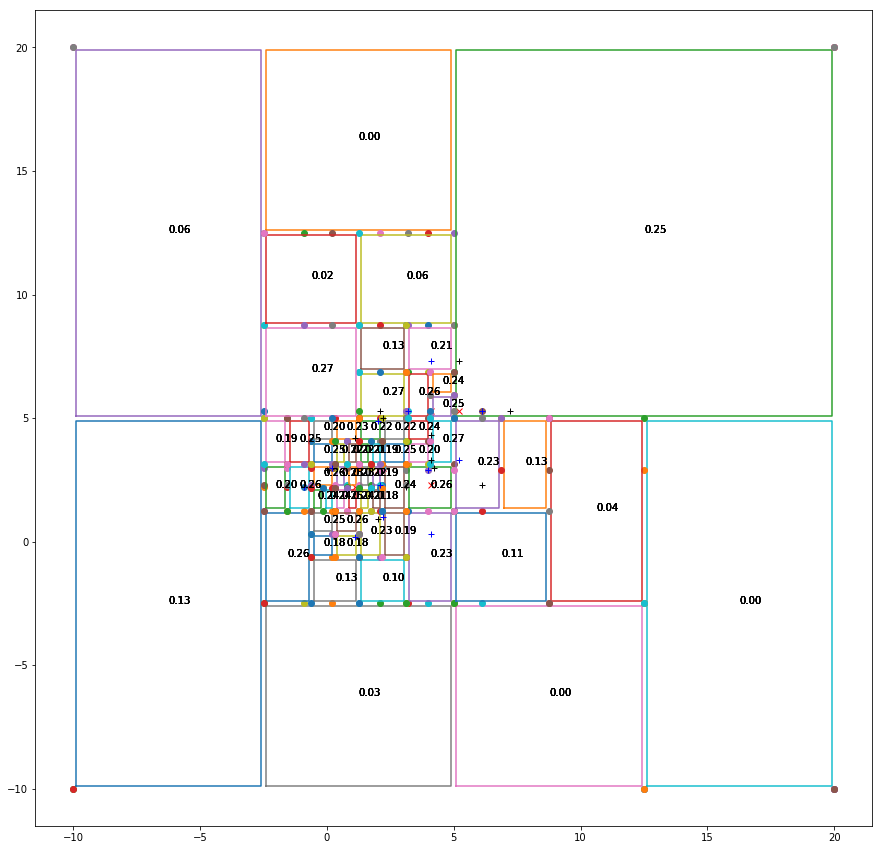

In [127]:

plt.figure(figsize=[15,15]) 
plt.plot(X[:,0],X[:,1],'rx')
for b in B:
    #plt.plot([b[0,0],b[0,0],b[0,1],b[0,1],b[0,0]],[b[1,0],b[1,1],b[1,1],b[1,0],b[1,0]])
    z = 0.1
    plt.plot([b[0,0]+z,b[0,0]+z,b[0,1]-z,b[0,1]-z,b[0,0]+z],[b[1,0]+z,b[1,1]-z,b[1,1]-z,b[1,0]+z,b[1,0]+z])
    peakgrad, peaklocs, peakvals = compute_box_bound(b,X,Y,l,0)
    for peak in peaklocs:
        plt.plot(peak[0,0],peak[0,1],'o')    
        plt.text(np.mean(b[0,:]),np.mean(b[1,:]),"%0.2f" % (peakgrad[0][0]))
    
for dim in range(X.shape[1]):
    for x,yind in zip(X[:,:],Y[:,:]):
        #maximum is at:
        #print(x[dim]-l*np.sign(yind))
        maxloc = x[dim]-l*np.sign(yind)
        minloc = x[dim]+l*np.sign(yind)
        temp = x.copy()
        temp[dim] = maxloc
        plt.plot(temp[0],temp[1],'b+')
        temp[dim] = minloc
        plt.plot(temp[0],temp[1],'k+')
#plt.xlim([2,5])
#plt.ylim([2,5])

In [95]:
#numerical approximation; grid search (lower bound)
xtest = []
for xi in np.arange(0,15,0.1):
    for xj in np.arange(0,15,0.1):
        xtest.append([xi,xj])
xtest = np.array(xtest)
res = getpred2grad(xtest,X,Y,dim=0,l=l)
np.max(res)

0.2256921335102697

/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


(-0.75873604800961247,
 15.645845072353593,
 -0.77723199255565545,
 15.64665843188477)

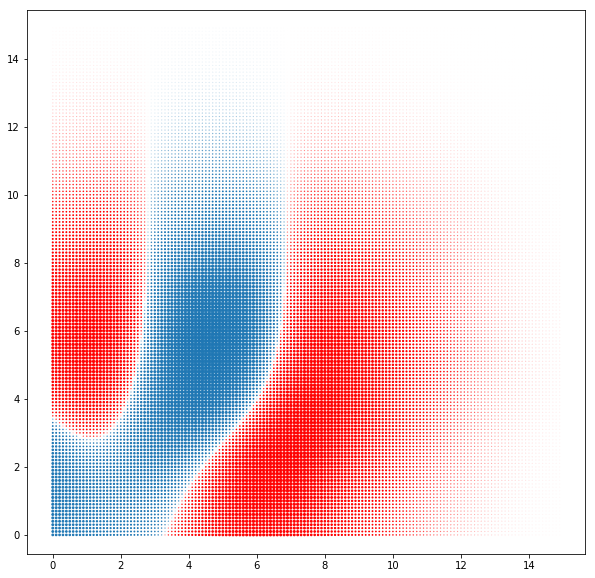

In [96]:
plt.figure(figsize=[10,10])
plt.scatter(xtest[:,0],xtest[:,1],50*res)
plt.scatter(xtest[:,0],xtest[:,1],-50*res,c='red')
plt.axis('equal')

In [97]:
#upper bound from analytical computation
peakgradslist = np.array([p[0,0] for p in peakgrads if p is not np.NaN])
np.max(peakgradslist)

0.2695668264680014

The upper bound is what we're interested in.
I also do a grid search (plotted). The greatest value of this grid search should be less than the computed analytical bound.

Notice how long it takes to get the lower bound from the grid search - we also can't even use that - as we don't know if the peak has fallen between the grid points.

Our upperbound was very quick to compute.

What we are actually interested in however, is how much moving along the dim=0 axis can cause a change in the output.

Trying to minimise the upper bound might not have been the most efficient option...

This loops through all the boxes. We really want to reduce the bound on the width * gradient of each box. This can be done by uncommenting the lines 20-21 in the earlier iterative box-splitting code:

        #pick box with max gradient*width bound
        #widths = np.array([np.diff(b[0]) for b in B])
        #maxbox = np.argmax(np.array(peakgrads)[:,:,0]*widths)

Also I need to find an algorithm to add together the right boxes to know how much moving from -10 to 20 could add to the output.

### Old test code

In [60]:
def kgrad(X,Xprime,dim,l=1): #UNTESTED DO NOT USE!
    """Gradient of kernel wrt one dimension
    Get covariance (using RBF with lengthscale l) between x and xprime"""
    res = np.zeros([X.shape[0],Xprime.shape[0]])
    for i,x in enumerate(X):
        for j,xprime in enumerate(Xprime):
            res[i,j] = np.exp(-.5*np.dot((x-xprime),(x-xprime).T)/(l**2))
            res[i,j]*= ((x-xprime)/(l**2))
    return res

def getpred(Xtest,X,Y,l):
    """Get a prediction at Xtest, using data X, y and kernel lengthscale l.
    Pass Xtest in as a 1xN array"""
    return np.dot(np.dot(k(Xtest,X,l),np.linalg.inv(k(X,X,l)+np.eye(len(X)))),Y)

def getpred2(Xtest,X,Y,l):
    alpha = np.dot(np.linalg.inv(k(X,X,l)+np.eye(len(X))),Y)
    pred = 0
    K = k(Xtest,X,l)   
    for a,kval in zip(alpha,K.T):        
        pred+=a*kval
    return pred

In [63]:
#test code...
X = np.array([[1.1,2.2],[2,2.9],[4.1,5.3]])*1.0
Y = np.array([[1],[-1],[-1]])*1.0
i = 0
delta = 0.000001
Xtest = np.array([[2,3]])*1.0
Xtestdelta = Xtest.copy()
Xtestdelta[0,i]+=delta
l = 5.0
print((getpred(Xtestdelta,X,Y,l)-getpred(Xtest,X,Y,l))/delta)
print(getpred2grad(Xtest,X,Y,0,l))

[[-0.07536622]]
[[-0.07536622]]
